# Implementation of a model for the localization of the legend of line graph images
This approach involves custom preprocessing of the input data

IMPORTARE IL DATASET CON LE ANNOTAZIONI

In [ ]:
!unzip ds.zip

!rm ds.zip

!mkdir output
!mkdir output/Plots

CONFIG FILE

In [ ]:
# import the necessary packages
import os

MAX_NUM_LINES = 10
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "FigureSeerDataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "Annotated_images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations.csv"])

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Plots/"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
TRAIN_FILENAMES = os.path.sep.join([BASE_OUTPUT, "train_images.txt"])
VALIDATION_FILENAMES = os.path.sep.join([BASE_OUTPUT, "validation_images.txt"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 1000
BATCH_SIZE = 4

IMG_HEIGHT = 176
IMG_WIDTH = 261

MODEL FILE

In [ ]:
!pip install tensorflow_addons

# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from typing import Optional

import tensorflow as tf
from typeguard import typechecked

from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import TensorLike


class EIoULoss(LossFunctionWrapper):

    @typechecked
    def __init__(
            self,
            mode: str = "eiou",
            reduction: str = tf.keras.losses.Reduction.AUTO,
            name: Optional[str] = "eiou_loss",
    ):
        super().__init__(eiou_loss, name=name, reduction=reduction, mode=mode)


def eiou_loss(y_true: TensorLike, y_pred: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """Implements the GIoU loss function.

    Args:
        y_true: true targets tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        y_pred: predictions tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        EIoU loss float `Tensor`.
    """
    if mode not in ["iou", "eiou"]:
        raise ValueError("Value of mode should be 'iou' or 'giou'")
    y_pred = tf.convert_to_tensor(y_pred)
    if not y_pred.dtype.is_floating:
        y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, y_pred.dtype)
    eiou = tf.squeeze(_calculate_eiou(y_pred, y_true, mode))

    return 1 - eiou


def _calculate_eiou(b1: TensorLike, b2: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """
    Args:
        b1: bounding box. The coordinates of the each bounding box in boxes are
            encoded as [y_min, x_min, y_max, x_max].
        b2: the other bounding box. The coordinates of the each bounding box
            in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        EIoU loss float `Tensor`.
    """
    zero = tf.convert_to_tensor(0.0, b1.dtype)
    b1_ymin, b1_xmin, b1_ymax, b1_xmax = tf.unstack(b1, 4, axis=-1)
    b2_ymin, b2_xmin, b2_ymax, b2_xmax = tf.unstack(b2, 4, axis=-1)
    b1_width = tf.maximum(zero, b1_xmax - b1_xmin)
    b1_height = tf.maximum(zero, b1_ymax - b1_ymin)
    b2_width = tf.maximum(zero, b2_xmax - b2_xmin)
    b2_height = tf.maximum(zero, b2_ymax - b2_ymin)
    b1_area = b1_width * b1_height
    b2_area = b2_width * b2_height

    intersect_ymin = tf.maximum(b1_ymin, b2_ymin)
    intersect_xmin = tf.maximum(b1_xmin, b2_xmin)
    intersect_ymax = tf.minimum(b1_ymax, b2_ymax)
    intersect_xmax = tf.minimum(b1_xmax, b2_xmax)
    intersect_width = tf.maximum(zero, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(zero, intersect_ymax - intersect_ymin)
    intersect_area = intersect_width * intersect_height

    union_area = b1_area + b2_area - intersect_area
    iou = tf.math.divide_no_nan(intersect_area, union_area)
    if mode == "iou":
        return iou

    enclose_ymin = tf.minimum(b1_ymin, b2_ymin)
    enclose_xmin = tf.minimum(b1_xmin, b2_xmin)
    enclose_ymax = tf.maximum(b1_ymax, b2_ymax)
    enclose_xmax = tf.maximum(b1_xmax, b2_xmax)
    enclose_width = tf.maximum(zero, enclose_xmax - enclose_xmin)
    enclose_height = tf.maximum(zero, enclose_ymax - enclose_ymin)

    b1_central_y = (b1_ymin + b1_height / 2)
    b1_central_x = (b1_xmin + b1_width / 2)
    b2_central_y = (b2_ymin + b2_height / 2)
    b2_central_x = (b2_xmin + b2_width / 2)

    central_width = (b1_central_x - b2_central_x)
    central_heigth = (b1_central_y - b2_central_y)

    central_distance = central_width * central_width + central_heigth * central_heigth

    enclose_diagonal = enclose_width * enclose_width + enclose_height * enclose_height

    width_diff = (b1_width - b2_width) * (b1_width - b2_width)

    heigth_diff = (b1_height - b2_height) * (b1_height - b2_height)

    eiou = iou - tf.math.divide_no_nan(central_distance, enclose_diagonal) \
           - tf.math.divide_no_nan(width_diff, enclose_width * enclose_width) \
           - tf.math.divide_no_nan(heigth_diff, enclose_height * enclose_height)

    return eiou

     |████████████████████████████████| 686kB 8.9MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from eiou_loss import EIoULoss
from tensorflow.keras.losses import MeanAbsoluteError, CategoricalCrossentropy, MeanSquaredLogarithmicError
from tensorflow.keras.metrics import Accuracy, MeanIoU
# import config
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow_addons.losses import GIoULoss



from tensorflow.keras import regularizers

def build_model():
    model = tf.keras.Sequential([
        # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_H, IMG_W, 3)),
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        layers.Conv2D(32, 11, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, 9, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        layers.Conv2D(128, 7, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        layers.Conv2D(256, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        layers.Conv2D(512, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(4, activation='sigmoid', name='bbox')
    ])

    plot_model(model, to_file= BASE_OUTPUT + '/my_model.png', show_shapes=True)

    return model

# def build_model():
#     # load the VGG16 network, ensuring the head FC layers are left off
#     input = Input(shape=(224, 224, 3))

#     vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#     print("STRUTTURA VGG16")
#     for layer in vgg.layers[:-4]:
#         layer.trainable = False
#     vgg.summary()
#     plot_model(vgg, to_file=BASE_OUTPUT + '/vgg_model.png', show_shapes=True)

#     x = vgg(input)
#     x = Conv2D(1024, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = Dropout(0.2)(x)
#     x = Conv2D(2048, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = Dropout(0.2)(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(128, activation='relu')(x)

#     # construct a fully-connected layer header to output the predicted
#     # bounding box coordinates

#     # legend_output = Flatten(input_shape=(7, 7, 512))(x)
#     # legend_output = Dense(256, activation='relu')(legend_output)
#     legend_output = Dropout(0.2)(x)
#     legend_output = Dense(4, activation='sigmoid', name='legend_bbox')(legend_output)

#     model = Model(input, legend_output)

#     # initialize the optimizer, compile the model, and show the model
#     # summary
#     model.summary()
#     plot_model(model, to_file=BASE_OUTPUT + '/model.png', show_shapes=True)

#     return model

# def get_model():
#     model = tf.keras.Sequential([
#         layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_H, IMG_W, 3)),
#         # layers.InputLayer(input_shape=(IMG_H, IMG_W, 1)),

#         layers.Conv2D(32, 3, activation='relu'),
#         layers.MaxPool2D(),
#         layers.Dropout(0.2),

#         layers.Conv2D(64, 3, activation='relu'),
#         layers.MaxPool2D(),
#         layers.Dropout(0.2),

#         layers.Conv2D(128, 3, activation='relu'),
#         layers.MaxPool2D(),
#         layers.Dropout(0.2),

#         layers.Conv2D(256, 3, activation='relu'),
#         layers.MaxPool2D(),
#         layers.Dropout(0.2),

#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         #layers.Dense(64, activation='relu'),
#         # layers.Dropout(0.2),

#         layers.Dense(4, activation='sigmoid', name='bbox')
#     ])

#     return model


def get_model():
    model = build_model()
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=EIoULoss(),
                  # loss=GIoULoss(mode='iou'),
                  # loss=tf.keras.losses.LogCosh(),
                  # loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[MeanAbsoluteError(), GIoULoss(mode='iou', name='iou_loss'), GIoULoss(), EIoULoss()])

    return model

TRAIN FILE

In [ ]:
def save_plot(plot_name, H, parameters, title, loss_plot=True):
    N = len(H.history['loss'])
    plt.style.use("ggplot")
    plt.figure()
    for parameter in parameters:
        plt.plot(np.arange(0, N), H.history[parameter], label=parameter)

    plt.title('\n'.join(wrap(title, 60)))
    plt.xlabel("Epoch #")
    if loss_plot:
        plt.legend(loc="upper right")
        plt.ylabel("Loss")
    else:
        plt.legend(loc="lower left")
        plt.ylabel("Accuracy")
    plt.savefig(PLOT_PATH + plot_name)

In [ ]:
# import the necessary packages
#from config import *

# import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
# from my_model import *
from textwrap import wrap
import random
import datetime

# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
axis_targets = []
num_lines_targets = []
filenames = []


# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY, a_startX, a_startY, a_endX, a_endY, num_lines) = row

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    a_startX = float(a_startX) / w
    a_startY = float(a_startY) / h
    a_endX = float(a_endX) / w
    a_endY = float(a_endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    axis_targets.append((a_startX, a_startY, a_endX, a_endY))
    # array = [0] * MAX_NUM_LINES
    # array[int(num_lines) - 1] = 1
    num_lines_targets.append(float(num_lines) / 10)
    filenames.append(filename)

# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
axis_targets = np.array(axis_targets, dtype="float32")
num_lines_targets = np.array(num_lines_targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
seed = random.randint(1, 101)

test_split = train_test_split(data, targets, axis_targets, num_lines_targets, filenames, test_size=0.20,
                         random_state=42)

# unpack the data split
(Images, testImages) = test_split[:2]
(Targets, testTargets) = test_split[2:4]
(axis_Targets, test_axis_Targets) = test_split[4:6]
(num_lines_Targets, test_num_lines_Targets) = test_split[6:8]
(Filenames, testFilenames) = test_split[8:]

split = train_test_split(Images, Targets, axis_Targets, num_lines_Targets, Filenames, test_size=0.20,
                         random_state=42)

(trainImages, valImages) = split[:2]
(trainTargets, valTargets) = split[2:4]
(train_axis_Targets, val_axis_Targets) = split[4:6]
(train_num_lines_Targets, val_num_lines_Targets) = split[6:8]
(trainFilenames, valFilenames) = split[8:]

print('dimensioni del training set :' + str(len(trainFilenames)))
print('dimensioni del validation set :' + str(len(valFilenames)))
print('dimensioni del test set :' + str(len(testFilenames)))

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor

print("[INFO] saving training filenames...")
f = open(TRAIN_FILENAMES, "w")
f.write("\n".join(trainFilenames))
f.close()

print("[INFO] saving validation filenames...")
f = open(VALIDATION_FILENAMES, "w")
f.write("\n".join(valFilenames))
f.close()

print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

# for image, target, a_target, nl_target in zip(trainImages, trainTargets, train_axis_Targets, train_num_lines_Targets):
#     print(image, target, a_target)
#     break

model = get_model()

log_dir = "output/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(valImages, valTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback, early_stopping],
    verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history

[INFO] loading dataset...
dimensioni del training set :592
dimensioni del validation set :149
dimensioni del test set :186
[INFO] saving training filenames...
[INFO] saving validation filenames...
[INFO] saving testing filenames...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 166, 251, 32)      11648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 125, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 83, 125, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 117, 64)       165952    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 58, 64)        0         
______________________

Disegna i grafici

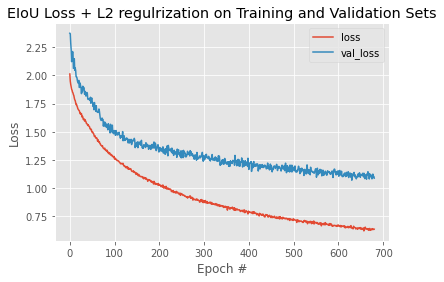

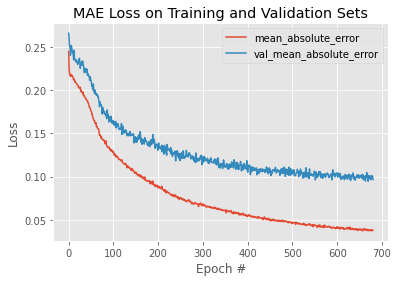

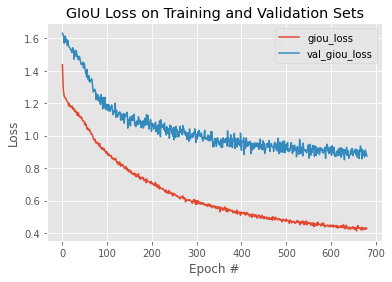

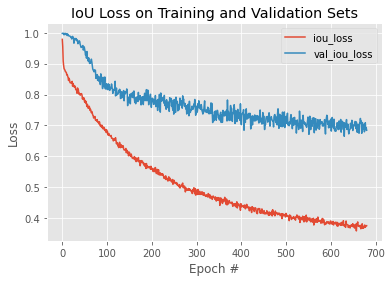

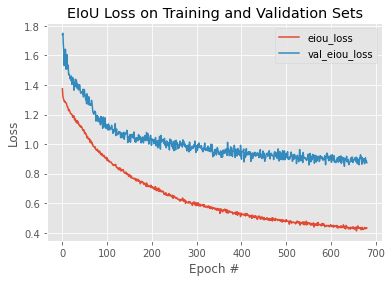

In [ ]:
save_plot('legend_loss.png', H, ['loss', 'val_loss'], 'EIoU Loss + L2 regulrization on Training and Validation Sets')
save_plot('mae_loss.png', H, ['mean_absolute_error', 'val_mean_absolute_error'], 'MAE Loss on Training and Validation Sets')
save_plot('giou_loss.png', H, ['giou_loss', 'val_giou_loss'], 'GIoU Loss on Training and Validation Sets')
save_plot('iou_loss.png', H, ['iou_loss', 'val_iou_loss'], 'IoU Loss on Training and Validation Sets')
save_plot('eiou_loss.png', H, ['eiou_loss', 'val_eiou_loss'], 'EIoU Loss on Training and Validation Sets')

# save_plot('num_lines_accuracy.png', H, ['num_lines_accuracy', 'val_num_lines_accuracy'], 'Accuracy of num lines prediction on Test and Validation sets', loss_plot=False)

In [ ]:
model.evaluate(trainImages, trainTargets)
model.evaluate(valImages, valTargets)
model.evaluate(testImages, testTargets)

6/6 [==============================] - 1s 108ms/step - loss: 0.9823 - mean_absolute_error: 0.0806 - iou_loss: 0.6036 - giou_loss: 0.7476 - eiou_loss: 0.7733


[0.9823006391525269,
 0.08063653856515884,
 0.6035816073417664,
 0.7476325035095215,
 0.7733095288276672]

PREDICT FILE

predire su training (1), su validation (2) o su training (3)?: 3
[INFO] loading object detector...
FigureSeerDataset/Annotated_images/00490-10.1.1.18.7410-Figure-1.png
Bbox della legenda attuale: 177 211 420 255
Bbox della legenda predetta: 151 196 407 262
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.5392666, shape=(), dtype=float32)


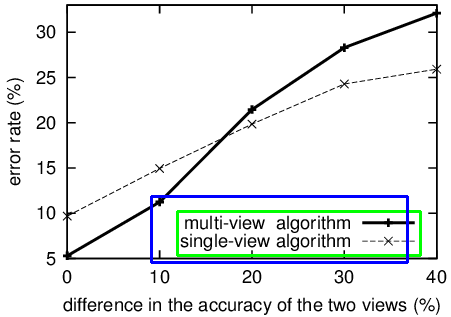

FigureSeerDataset/Annotated_images/01493-10.1.1.132.2653-Figure-11.png
Bbox della legenda attuale: 93 42 252 119
Bbox della legenda predetta: 77 11 257 93
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.6056905, shape=(), dtype=float32)


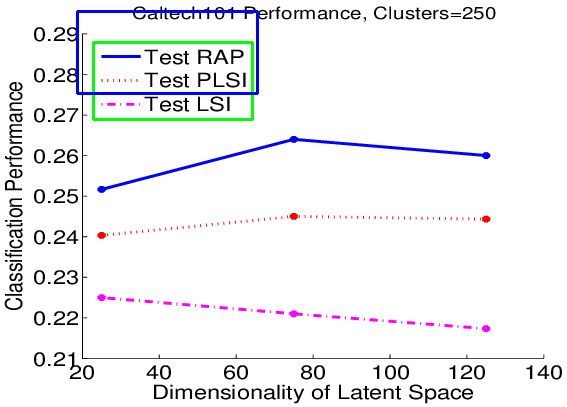

FigureSeerDataset/Annotated_images/00079-10.1.1.149.7852-Figure-2.png
Bbox della legenda attuale: 189 9 412 48
Bbox della legenda predetta: 147 31 327 69
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.90963936, shape=(), dtype=float32)


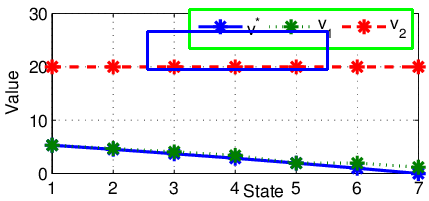

FigureSeerDataset/Annotated_images/00178-10.1.1.39.8052-Figure-6.png
Bbox della legenda attuale: 220 22 581 107
Bbox della legenda predetta: 248 42 561 121
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.44335413, shape=(), dtype=float32)


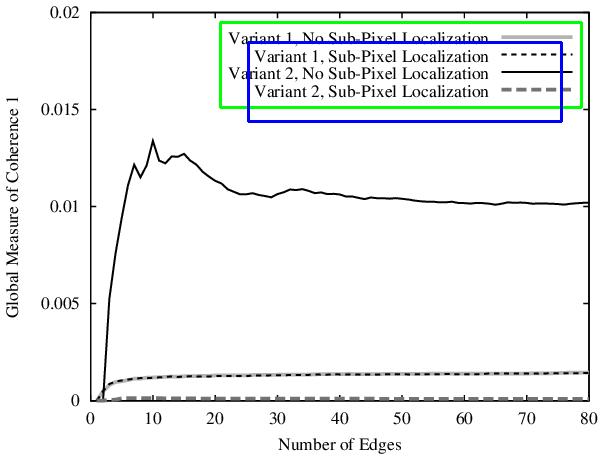

FigureSeerDataset/Annotated_images/02662-10.1.1.367.8234-Figure-6.png
Bbox della legenda attuale: 121 91 286 144
Bbox della legenda predetta: 115 52 303 148
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.7386069, shape=(), dtype=float32)


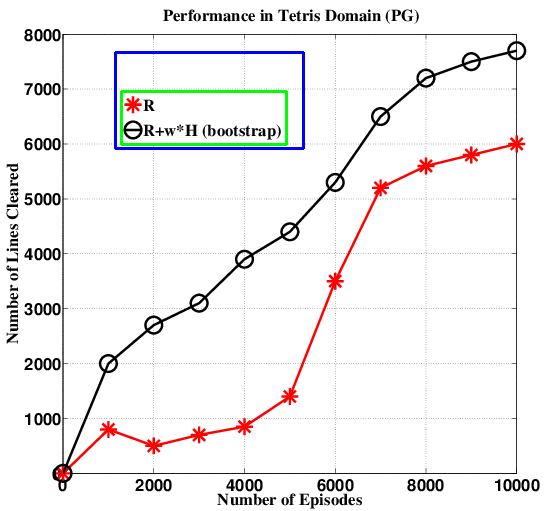

FigureSeerDataset/Annotated_images/03180-10.1.1.14.3650-Figure-2.png
Bbox della legenda attuale: 354 16 516 47
Bbox della legenda predetta: 309 58 466 89
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(1.0840292, shape=(), dtype=float32)


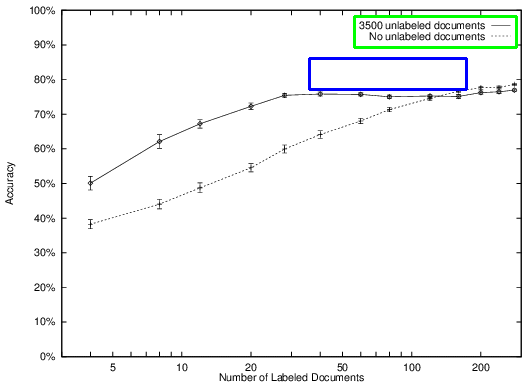

FigureSeerDataset/Annotated_images/01217-10.1.1.170.2394-Figure-3.png
Bbox della legenda attuale: 75 45 245 162
Bbox della legenda predetta: 106 43 253 157
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.2873732, shape=(), dtype=float32)


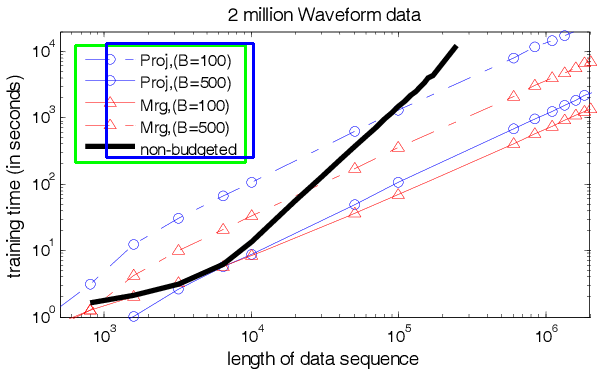

FigureSeerDataset/Annotated_images/00286-10.1.1.225.6195-Figure-4.png
Bbox della legenda attuale: 290 195 464 298
Bbox della legenda predetta: 275 181 437 268
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.53729546, shape=(), dtype=float32)


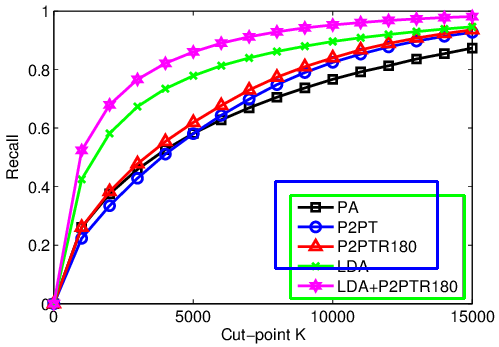

FigureSeerDataset/Annotated_images/01024-10.1.1.408.772-Figure-4.png
Bbox della legenda attuale: 406 17 538 49
Bbox della legenda predetta: 364 65 496 110
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(1.1411648, shape=(), dtype=float32)


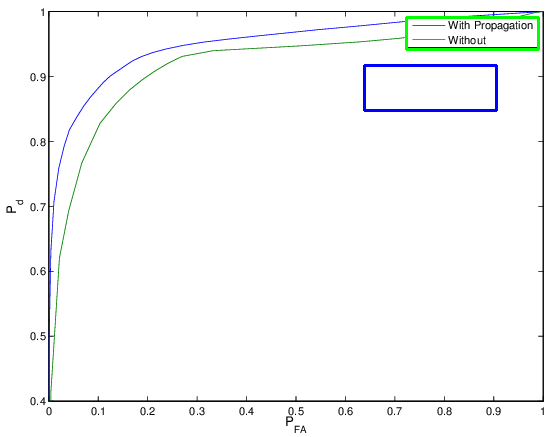

FigureSeerDataset/Annotated_images/00916-10.1.1.368.1401-Figure-6.png
Bbox della legenda attuale: 258 231 457 277
Bbox della legenda predetta: 194 202 397 274
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.8393077, shape=(), dtype=float32)


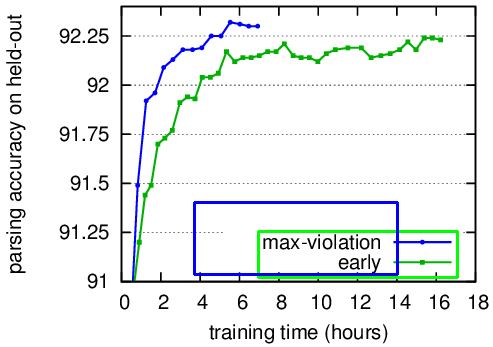

FigureSeerDataset/Annotated_images/00161-10.1.1.37.1152-Figure-12.png
Bbox della legenda attuale: 222 266 578 393
Bbox della legenda predetta: 208 260 551 388
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.18469435, shape=(), dtype=float32)


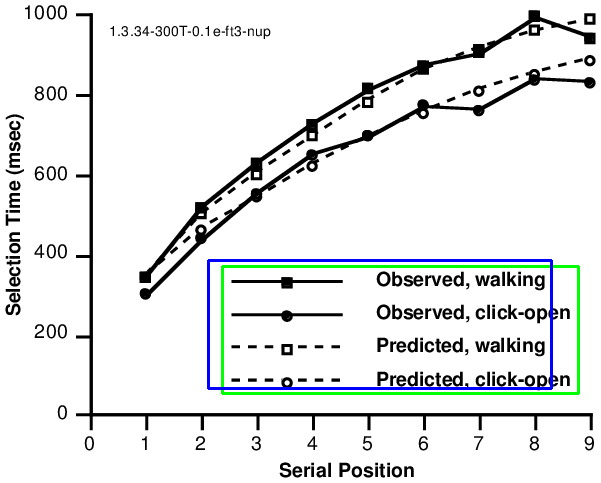

FigureSeerDataset/Annotated_images/02126-10.1.1.385.5289-Figure-7.png
Bbox della legenda attuale: 101 276 192 339
Bbox della legenda predetta: 275 117 518 177
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(1.528528, shape=(), dtype=float32)


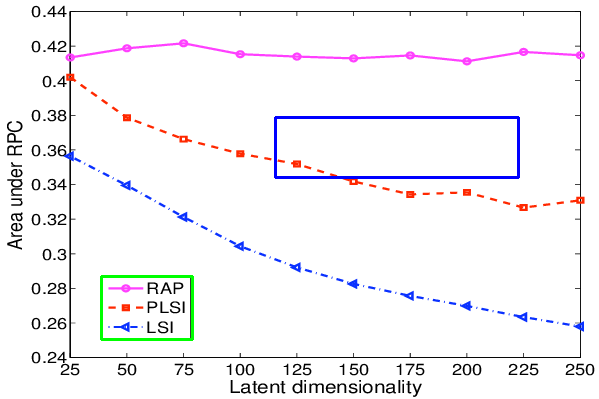

FigureSeerDataset/Annotated_images/03064-10.1.1.318.2358-Figure-6.png
Bbox della legenda attuale: 87 80 306 233
Bbox della legenda predetta: 103 53 300 187
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.4952135, shape=(), dtype=float32)


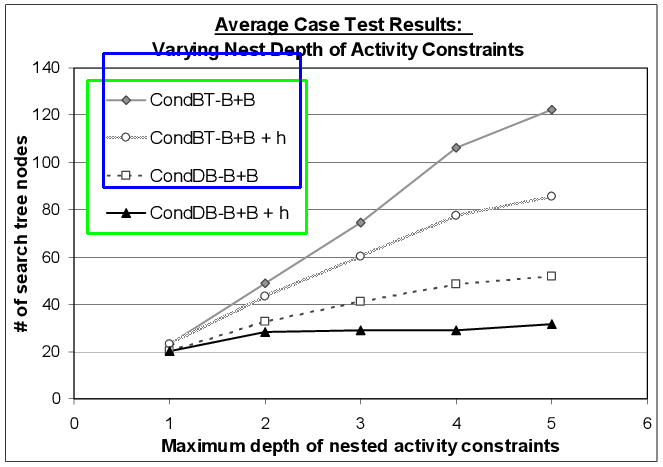

FigureSeerDataset/Annotated_images/02534-10.1.1.393.71-Figure-3.png
Bbox della legenda attuale: 94 17 283 106
Bbox della legenda predetta: 147 54 291 136
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.76632667, shape=(), dtype=float32)


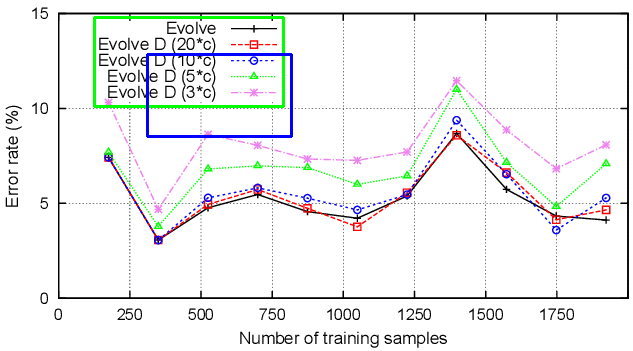

FigureSeerDataset/Annotated_images/01883-10.1.1.36.1710-Figure-14.png
Bbox della legenda attuale: 357 46 598 115
Bbox della legenda predetta: 335 28 589 111
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.3667034, shape=(), dtype=float32)


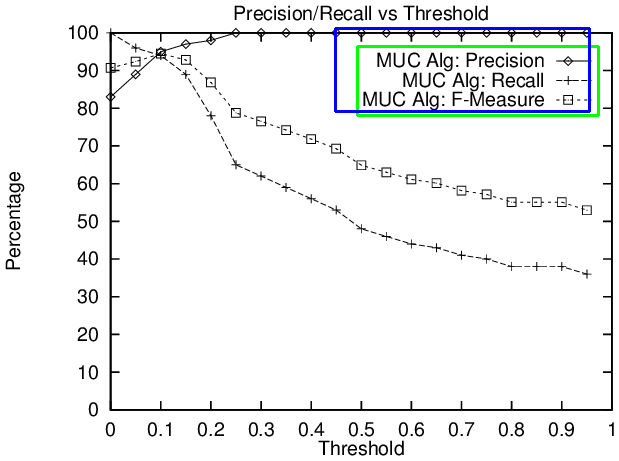

FigureSeerDataset/Annotated_images/00749-10.1.1.208.3744-Figure-5.png
Bbox della legenda attuale: 425 319 595 430
Bbox della legenda predetta: 380 281 549 377
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.81290764, shape=(), dtype=float32)


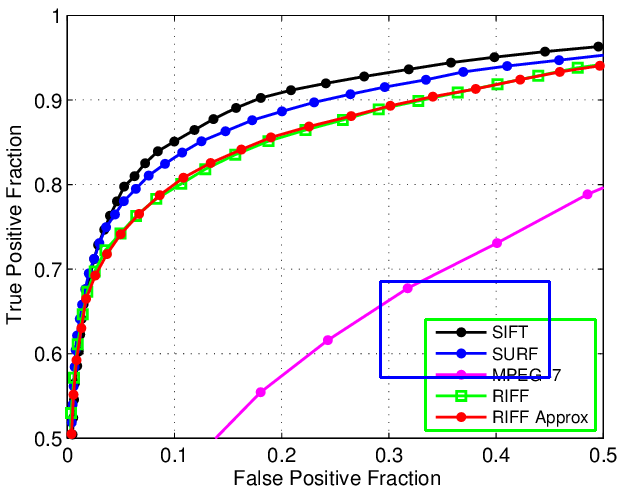

FigureSeerDataset/Annotated_images/02460-10.1.1.15.3331-Figure-5.png
Bbox della legenda attuale: 498 34 628 104
Bbox della legenda predetta: 301 179 514 234
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(1.3632979, shape=(), dtype=float32)


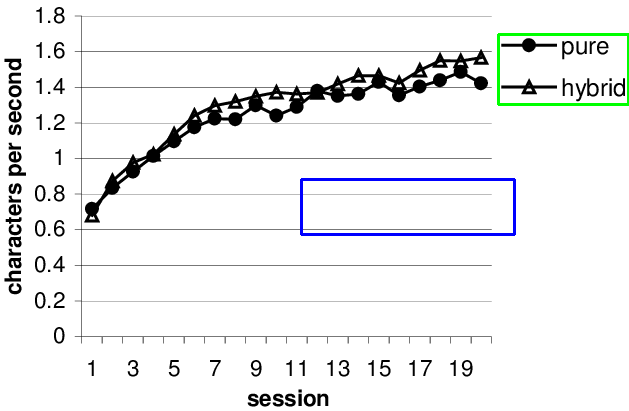

FigureSeerDataset/Annotated_images/03119-10.1.1.228.6129-Figure-6.png
Bbox della legenda attuale: 365 18 596 64
Bbox della legenda predetta: 373 24 595 81
grado di divergenza delle bbox delle legende basato su EIoU loss function: tf.Tensor(0.41785806, shape=(), dtype=float32)


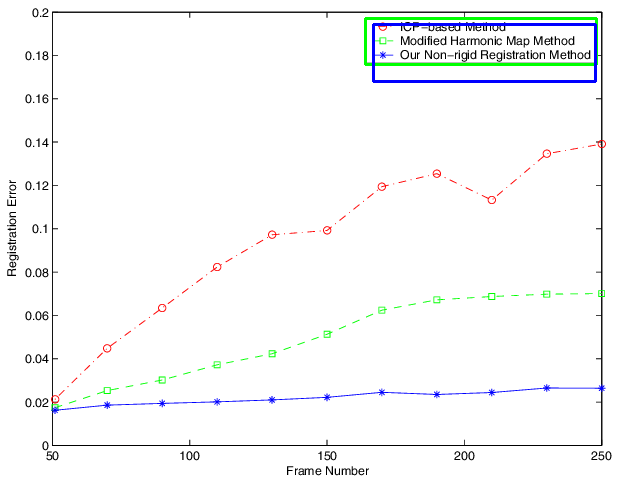

In [ ]:
# import the necessary packages
# import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
# import tensorflow_addons as tfa
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os
from google.colab.patches import cv2_imshow


def get_EIoULoss(gt_bbox, pred_bbox):
    lf = EIoULoss()
    loss = lf(gt_bbox, pred_bbox)
    return loss

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
#                 help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# # determine the input file type, but assume that we're working with
# # single input image
# filetype = mimetypes.guess_type(args["input"])[0]
# imagePaths = [args["input"]]
# if the file type is a text file, then we need to process *multiple*
# images

switch = input("predire su training (1), su validation (2) o su training (3)?: ")
if switch == str(1):
    args = 'output/train_images.txt'
elif switch == str(2):
    args = 'output/validation_images.txt'
else:
    args = 'output/test_images.txt'

filetype = 'text/plain'
imagePaths = [args]
annotsPaths = []

if "text/plain" == filetype:
    # load the filenames in our testing file and initialize our list
    # of image paths
    filenames = open(args).read().strip().split("\n")
    imagePaths = []
    # loop over the filenames
    for f in filenames:
        for row in rows:
            row = row.split(",")
            if f == row[0]:
                annotsPaths.append(row[1:])
        # construct the full path to the image filename and then
        # update our image paths list
        p = os.path.sep.join([IMAGES_PATH, f])
        imagePaths.append(p)

# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
# model = load_model(MODEL_PATH, compile=False)
# loop over the images that we'll be testing using our bounding box
# regression model
i = 0
while i < int(len(imagePaths) / 10):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    print(imagePaths[i])
    image = load_img(imagePaths[i], target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model.predict(image)

    (startX, startY, endX, endY) = preds[0]

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePaths[i])
    # image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions

    if annotsPaths:
        annots = []
        for annot in annotsPaths[i]:
            annots.append(int(annot))
        (gt_l_startX, gt_l_startY, gt_l_endX, gt_l_endY, gt_a_startX, gt_a_startY, gt_a_endX, gt_a_endY, gt_num_lines) = annots

        # print('numero di linee attuale: ' + str(gt_num_lines))
        print('Bbox della legenda attuale: ' + str(gt_l_startX), str(gt_l_startY), str(gt_l_endX), str(gt_l_endY))
        gt_legend_bbox = tf.constant([[gt_l_startX, gt_l_startY, gt_l_endX, gt_l_endY]])

        # draw the predicted bounding box on the image
        cv2.rectangle(image, (gt_l_startX, gt_l_startY), (gt_l_endX, gt_l_endY), (0, 255, 0), 2)

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    print('Bbox della legenda predetta: ' + str(startX), str(startY), str(endX), str(endY))

    pred_legend_bbox = tf.constant([[startX, startY, endX, endY]])
    print(
            'grado di divergenza delle bbox delle legende basato su EIoU loss function: ' + str(get_EIoULoss(gt_legend_bbox,
                                                                                                             pred_legend_bbox)))

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),
                  (255, 0, 0), 2)

    # show the output image
    cv2_imshow(image)
    k = cv2.waitKeyEx(0)

    if k == 27:  # close on ESC key
        break
    if k == 2424832:  # get back on left arrow key
        i = i - 1
    else:
        i += 1


In [ ]:
!zip -r output.zip output/

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir output/logs/fit